# Projekt Zaliczeniowy Modelowanie w Naukach o Ziemi

Projekt jest na ocenę. Rezultatem ma być kompletne sprawozdanie. Sprawozdania w formacie pdf przesyłamy w terminie do ostatniego dnia semestru.

Dane do projektu: `plik daily_ice_edge.csv`.

### Krok 0

1. Po przemyśleniu układu danych narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów. 

  a. Przemyśleć układ danych
  
  b. Narysować kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów

Warto zapoznać się z kształtem Antarktydy.   

### Krok 1
  
1. Dla wszystkich kątów (dla każdego z osobna) znaleźć model matematyczny zasięgu lodu w funkcji czasu. 

  a. Zbudować model matematyczny dla każdej kolumny w oparciu o funkcji trygonometryczne (sinusoidalna cykliczność; można o to zapytać).

Uwaga na próbkowanie w czasie oraz na fakt, że czasami lodu morskiego dla danego kąta może nie być. 

### Krok 2
  
1. Stworzyć animację przedstawiającą zmianę w czasie zarówno rzeczywistego jak i wymodelowane.

### Krok 3
 
1. Zaproponować i *w miarę możliwości* obliczyć model zasięgu lodu biorący pod uwagę wszystkie dane na raz (`f(Lat, Lon, t)`).

  a. Przekonać, że świta nam w głowie jakaś idea.

## Wskazówki 

Można zbudować model bazując na sinusach i cosinusach dla każdego kierunku z osobna. Po powtórzeniu dla wszystkich azymutów pojawi się macierz, którą animujemy.

Po narysowaniu minimalnego zasięgu lodu w układzie biegunowym otrzymamy minimalny zasięg lodu przypominający kształt Antarktydy. Uzyskujemy to poprzez znalezienie minimalnej wartości w każdej kolumnie i narysowanie tego w układzie biegunowym.


In [20]:
# install.packages("ggplot2") # nolint: commented_code_linter.
# install.packages("animation") # nolint: commented_code_linter.
# install.packages("tidyverse") # nolint: commented_code_linter.
# install.packages("lubridate") # nolint: commented_code_linter.
# install.packages("minpack.lm") # nolint: commented_code_linter.
library(ggplot2)
library(animation)
library(tidyverse)
library(lubridate)
library(minpack.lm)


## Dane do projektu

Plik `daily_ice_edge.csv` zawiera informację o zasięgu lodu morskiego wokół Antarktydy dla wszystkich długości geograficznych - w formacie długość-szerokość - na przestrzeni wielu lat. Dane są zapisane w formie macierzy, gdzie wiersze odpowiadają szerokości geograficznej, a kolumny długości geograficznej.

In [21]:
path <- "./data/daily_ice_edge.csv"
daily_ice_edge <- read.csv(path)
# 1591 wiersz -> zaczynają się dane codzienne


In [22]:
# View(daily_ice_edge) # nolint: commented_code_linter.
# View(daily_open_water) # nolint: commented_code_linter.

## Minimalny zasięg lodu na Antarktydzie

Kontur przedstawiający minimalny zasięg lodu w analizowanym okresie dla wszystkich kątów

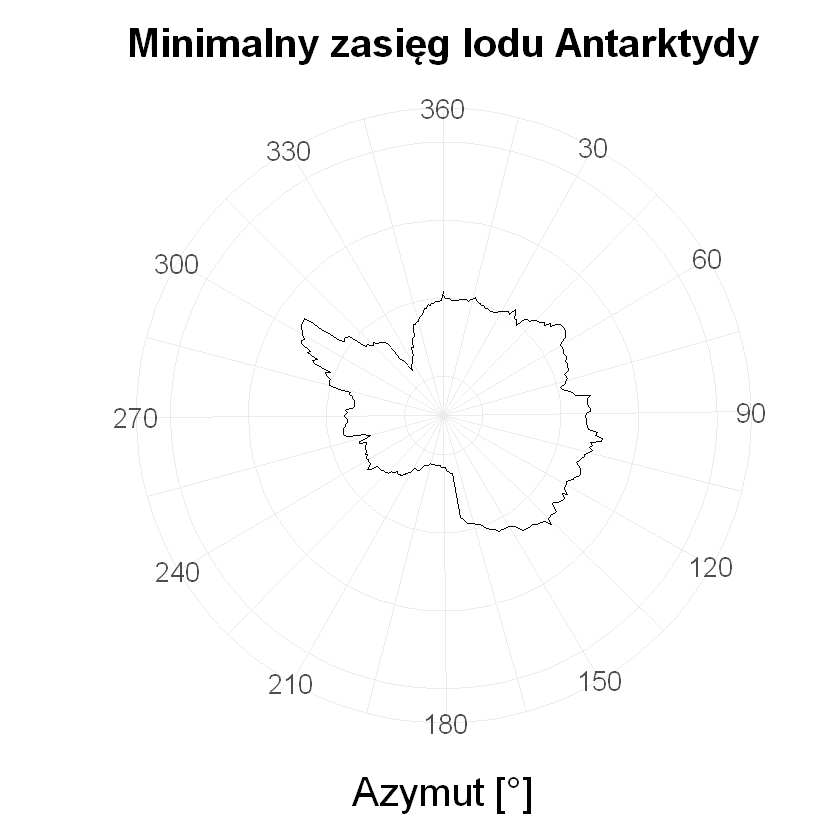

In [23]:
ice_edge_colnum <- length(colnames(daily_ice_edge))

ice_edge_min <- c()
open_water_min <- c()

for (i in 2:(ice_edge_colnum - 1)) {
  ice_edge_min[i - 1] <- min(daily_ice_edge[, i], na.rm = TRUE)
}
ice_edge_min <- as.data.frame(ice_edge_min)

ggplot(
  data = ice_edge_min, aes(x = seq_along(ice_edge_min), y = ice_edge_min)
) +
  geom_line() +
  coord_polar() +
  theme_minimal() +
  ylim(-85, -50) +
  labs(
    title = "Minimalny zasięg lodu Antarktydy",
    x = "Azymut [°]", y = ""
  ) +
  scale_x_continuous(breaks = seq(0, 360, 30)) +
  theme(
    axis.text.x = element_text(size = 16),
    axis.text.y = element_blank(),
    axis.title = element_text(size = 24),
    plot.title = element_text(size = 24, face = "bold", hjust = 0.5),
    plot.margin = unit(c(16, 16, 16, 16), "pt")
  )

## Animacja czasu rzeczywistego

In [24]:
step <- 50
interval <- 0.4

sequence <- seq(from = 1, to = nrow(daily_ice_edge), by = step)

saveGIF(
  for (i in sequence) {
    day1 <- t(daily_ice_edge[i, ])

    start_index <- 2
    end_index <- 361

    angles <- c()
    for (j in seq(start_index, end_index, 1)) angles[j] <- day1[j]

    angles <- as.data.frame(angles)
    values <- as.numeric(angles[2:361, ])
    angles <- as.numeric(seq(start_index, end_index, 1))

    df <- data.frame(angles = angles, values = values)
    plt <- ggplot(data = df, aes(x = angles, y = values)) +
      geom_line() +
      coord_polar() +
      theme_minimal() +
      ylim(-85, -50) +
      labs(
        title = paste("Zasięg lodu na Antarktydzie dnia ", format(
          daily_ice_edge$Date[i]
        )),
        x = "Azymut [°]", y = ""
      ) +
      scale_x_continuous(breaks = seq(0, 360, 30)) +
      theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.title = element_text(size = 24),
        plot.title = element_text(size = 32, face = "bold", hjust = 0.5),
        plot.margin = unit(c(16, 16, 16, 16), "pt")
      )
    print(plt)
  },
  movie.name = "real-animation.gif", interval = interval,
  ani.width = 1200, ani.height = 800
)

Output at: real-animation.gif



[1] TRUE

## Model matematyczny

Dla każdego azymutu w oparciu o funkcji trygonometryczne 

In [25]:
data <- read.csv(path)
data$Date <- dmy(data$Date) # Konwersja na typ danych daty
data$Days <- as.numeric(
  data$Date - min(data$Date)
) # Obliczenie liczby dni od początku pomiarów

sine_model <- function(x, A, B, C, D) { # nolint: object_name_linter.
  A * sin(B * x + C) + D
}
# A - amplituda
# B - częstotliwość
# C - przesunięcie fazowe
# D - przesunięcie pionowe
model_params <- list()

# Obliczenie parametrów modelu dla każdej szerokości geograficznej
for (i in seq(2, 361, 1)) {
  col <- names(data)[i]
  day <- data$Days
  ice_extent <- data[[col]]

  init_params <- list(
    A = 1,
    B = 2 * pi / 365.25,
    C = 0,
    D = mean(ice_extent, na.rm = TRUE)
  )

  fit <- nlsLM(
    ice_extent ~ sine_model(day, A, B, C, D),
    start = init_params,
    control = nls.lm.control(maxiter = 1024)
  )

  model_params[[col]] <- coef(fit)
}


In [26]:
day <- data$Days
day_num <- length(day)
azimuths_num <- length(model_params)

time <- seq(1, day_num, 1) # nolint: object_name_linter.

results <- data.frame(matrix(nrow = length(day), ncol = azimuths_num))
names(results) <- paste0("azimuth_", seq(1, azimuths_num, 1))

for (i in seq(1, length(model_params), 1)) {
  params <- model_params[[col]]
  ice_extent <- data$params

  Y <- sine_model( # nolint: object_name_linter.
    time, params["A"], params["B"], params["C"], params["D"]
  )

  results[, i] <- Y

  col <- names(data)[i + 1]

  a <- round(params["A"], 2)
  b <- round(params["B"], 2)
  c <- round(params["C"], 2)
  d <- round(params["D"], 2)

  cat(
    "Wzór:", col, "y =", a, "sin(", b, "t +", c, ") +", d, "\n"
  )
}


Wzór: longitude_0E y = 7.7 sin( 0.02 t + 0.77 ) + -62.33 
Wzór: longitude_1E y = 7.94 sin( 0.02 t + 0.76 ) + -62.46 
Wzór: longitude_2E y = 8.1 sin( 0.02 t + 0.77 ) + -62.56 
Wzór: longitude_3E y = 8.12 sin( 0.02 t + 0.76 ) + -62.57 
Wzór: longitude_4E y = 8.09 sin( 0.02 t + 0.76 ) + -62.56 
Wzór: longitude_5E y = 8.14 sin( 0.02 t + 0.75 ) + -62.57 
Wzór: longitude_6E y = 8.16 sin( 0.02 t + 0.74 ) + -62.53 
Wzór: longitude_7E y = 8.16 sin( 0.02 t + 0.73 ) + -62.49 
Wzór: longitude_8E y = 8.16 sin( 0.02 t + 0.73 ) + -62.43 
Wzór: longitude_9E y = 8.15 sin( 0.02 t + 0.71 ) + -62.38 
Wzór: longitude_10E y = 8.13 sin( 0.02 t + 0.71 ) + -62.31 
Wzór: longitude_11E y = 8.03 sin( 0.02 t + 0.71 ) + -62.22 
Wzór: longitude_12E y = 7.91 sin( 0.02 t + 0.7 ) + -62.15 
Wzór: longitude_13E y = 7.79 sin( 0.02 t + 0.69 ) + -62.11 
Wzór: longitude_14E y = 7.7 sin( 0.02 t + 0.68 ) + -62.12 
Wzór: longitude_15E y = 7.64 sin( 0.02 t + 0.67 ) + -62.18 
Wzór: longitude_16E y = 7.51 sin( 0.02 t + 0.66 ) + -6

## Animacja modelu

In [27]:
saveGIF(
  for (i in seq(1, nrow(results), step)) {
    plt <- ggplot() +
      geom_line(aes(x = seq(1, azimuths_num, 1), y = unlist(results[i, ]))) +
      coord_polar() +
      scale_y_continuous(limits = c(-85, -50)) +
      theme_minimal() +
      labs(
        title = paste(
          "Modelowany zasięg lodu na Antarktydzie dnia ",
          format(daily_ice_edge$Date[i])
        ),
        x = "Azymut [°]", y = ""
      ) +
      scale_x_continuous(breaks = seq(0, 360, 30)) +
      theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.title = element_text(size = 24),
        plot.title = element_text(size = 32, face = "bold", hjust = 0.5),
        plot.margin = unit(c(16, 16, 16, 16), "pt")
      )

    print(plt)
  },
  movie.name = "model-animation.gif", interval = interval,
  ani.width = 1200, ani.height = 800
)


Output at: model-animation.gif



[1] TRUE

## Łączona animacja

In [28]:
sequence <- seq(from = 1, to = nrow(daily_ice_edge), by = step)

saveGIF(
  for (i in sequence) {
    day1 <- t(daily_ice_edge[i, ])

    start_index <- 2
    end_index <- 361

    angles <- c()
    for (j in seq(start_index, end_index, 1)) angles[j] <- day1[j]

    angles <- as.data.frame(angles)
    values <- as.numeric(angles[2:361, ])
    angles <- as.numeric(seq(start_index, end_index, 1))

    df <- data.frame(angles = angles, values = values)
    plt <- ggplot() +
      geom_line(aes(x = df$angles, y = df$values, colour = "Rzeczywisty")) +
      geom_line(aes(
        x = seq(1, azimuths_num, 1), y = unlist(results[i, ]),
        colour = "Wymodelowany"
      )) +
      scale_color_manual(
        name = "Zasięg lodu",
        values = c("Rzeczywisty" = "black", "Wymodelowany" = "red")
      )  +
      coord_polar() +
      theme_minimal() +
      ylim(-85, -50) +
      labs(
        title = paste("Zasięg lodu na Antarktydzie dnia ", format(
          daily_ice_edge$Date[i]
        )),
        x = "Azymut [°]", y = ""
      ) +
      scale_x_continuous(breaks = seq(0, 360, 30)) +
      theme(
        axis.text.x = element_text(size = 16),
        axis.text.y = element_blank(),
        axis.title = element_text(size = 24),
        plot.title = element_text(size = 32, face = "bold", hjust = 0.5),
        plot.margin = unit(c(16, 16, 16, 16), "pt"),
        legend.key.size = unit(24, "pt"),
        legend.text = element_text(size = 24),
        legend.title = element_text(size = 32, face = "bold")
      )
    print(plt)
  },
  movie.name = "combined-animation.gif", interval = interval,
  ani.width = 1200, ani.height = 800
)

Output at: combined-animation.gif



[1] TRUE

## Funkcja z 3 parametrami

In [37]:
predict_ice_extent <- function(lat, lon, t) {
  target_lon <- paste("longitude_", lon, "E", sep = "")
  params <- model_params[[target_lon]]
  sine_model(t, params["A"], params["B"], params["C"], params["D"])
}

lat <- 100
lon <- 10
t <- 1

predicted_extent <- predict_ice_extent(lat = lat, lon = lon, t = t)
cat(
  "Zasięg lodu na szerokości geograficznej", lat, "° i długości",
  lon, "° w czasie t = ", t, "wynosi: ", predicted_extent, "\n"
)


Zasięg lodu na szerokości geograficznej 100 ° i długości 10 ° w czasie t =  1 wynosi:  -56.21737 
